# Lid-driven cavity problem: classical

This is our starting point. By implimenting a simple classical ldc solutionm, we can begin to replicate a quantum simulator. This will use the finite volume method for a 2D laminar RANS SIMPLE algorithm.

##### Importing modules

In [111]:
import argparse
import logging
from dataclasses import dataclass, field
from time import perf_counter
from typing import Dict, List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d

def try_import_numba():
    try:
        import numba as _numba  # type: ignore
        return _numba.njit, True
    except Exception:
        # Fallback no-op decorator if numba is unavailable
        def _noop(func):
            return func
        return _noop, False

njit, NUMBA_AVAILABLE = try_import_numba()

##### Setting up a benchmark observation data to validate the theoretical solution. This is from the1982 Ghia et all database 

In [112]:
# Ghia et al data for comparision in velocity profile
def get_benchmark_profiles(
    re: float,
    length: float,
    source: str = "ghia",
):
    """
    Returns the benchmark centerline profiles for lid-driven cavity at a given Re from the Ghia et all dataset.
    The script will default to the closest available Re in the dataset if not found and will print warning that
    exact benchmark is not available.

    Returns a dict with these keys:
      x_ghia, v_ghia   # horisontal centerline y = L/2, v(x)
      y_ghia, u_ghia   # vertical centerline x = L/2, u(y)
      re               # reference Re actually used

    For completeness, if no benchmark is available, returns None.
    """

    if source.lower() != "ghia":
        return None  # Just in case I decide to add more sources.

    # This is a benchmark observation from Ghia et al. (1982) for common Re numbers.
    # With coordinates within the unit square, these velocities are nondimensional ie U_lid = 1.
    GHIA_DB = {
        100: {
            "y": np.array([0.0, 0.0547, 0.0625, 0.0703, 0.1016, 0.1719, 0.2813, 0.4531, 0.5, 0.6172, 0.7344, 0.8516, 0.9531, 0.9609, 0.9688, 0.9766, 1.0]),
            "u": np.array([0.0, -0.03717, -0.04192, -0.04775, -0.06434, -0.10150, -0.15662, -0.21090, -0.20581, -0.13641, 0.00332, 0.23151, 0.68717, 0.73722, 0.78871, 0.84123, 1.0]),
            "x": np.array([0.0, 0.0625, 0.0703, 0.0781, 0.0938, 0.1563, 0.2266, 0.2344, 0.5, 0.8047, 0.8594, 0.9063, 0.9453, 0.9531, 0.9609, 0.9688, 1.0]),
            "v": np.array([0.0, 0.09233, 0.10091, 0.10890, 0.12317, 0.16077, 0.17507, 0.17527, 0.05454, -0.24533, -0.22445, -0.16914, -0.10313, -0.08864, -0.07391, -0.05906, 0.0]),
        },
        # ADD MORE SETS LIKE 400: {...}, 1000: {...}, 3200: {...}
    }

    available = sorted(GHIA_DB.keys())

    # Good practice: if called and nothing is in the database, it will return None
    if not available:
        return None

    # Since the reference L of the domain might not be unity, I'm just scaling them to whatever the domain required is.
    re_ref = min(available, key=lambda R: abs(R - re))
    d = GHIA_DB[re_ref]
    return {
        "y_ghia": d["y"] * length,   # scale coords to the physical L
        "u_ghia": d["u"],            # As stated before, the velocities are nondimensional
        "x_ghia": d["x"] * length,
        "v_ghia": d["v"],            # velocity = nondimensional, U_Lid = 1
        "re": re_ref,
    }

    # Finds the nearest available Re if the one requested is not in the database
    if len(available) == 1:
        re_ref = min(available, key=lambda R: abs(R - re))
        return _format_result(re_ref)

##### Define global storage

In [113]:
# Global dictionary to store solver data for each scheme
solvers_data: Dict[str, "SolverState"] = {}

# Global dictionary to store computation time for each scheme
solution_times: Dict[str, Dict[str, list[float]]] = {}

##### Define dataclass for storing solver state information

In [114]:
@dataclass
class SolverState:
    # Basic parameters
    length: float
    nx: int
    ny: int
    rho: float
    nu: float
    u_lid: float
    scheme: str
    alpha_u: float
    alpha_v: float
    alpha_p: float
    convergence_criterion: float = 1e-5

    # Derived
    dx: float = field(init=False)
    dy: float = field(init=False)
    mu: float = field(init=False)
    Re: float = field(init=False)

    # Solution fields (staggered grid)
    u: np.ndarray = field(init=False)  # (nx+1, ny+2)
    v: np.ndarray = field(init=False)  # (nx+2, ny+1)
    p: np.ndarray = field(init=False)  # (nx+2, ny+2)
    p_corr: np.ndarray = field(init=False)  # (nx+2, ny+2)

    # Coefficients for momentum equations
    ae_u: np.ndarray = field(init=False)
    aw_u: np.ndarray = field(init=False)
    an_u: np.ndarray = field(init=False)
    as_u: np.ndarray = field(init=False)
    ap_u: np.ndarray = field(init=False)
    b_u: np.ndarray = field(init=False)

    ae_v: np.ndarray = field(init=False)
    aw_v: np.ndarray = field(init=False)
    an_v: np.ndarray = field(init=False)
    as_v: np.ndarray = field(init=False)
    ap_v: np.ndarray = field(init=False)
    b_v: np.ndarray = field(init=False)

    # Coefficients for pressure correction
    ae_p: np.ndarray = field(init=False)
    aw_p: np.ndarray = field(init=False)
    an_p: np.ndarray = field(init=False)
    as_p: np.ndarray = field(init=False)
    ap_p: np.ndarray = field(init=False)
    b_p: np.ndarray = field(init=False)

    # Grid for plotting
    x_cell: np.ndarray = field(init=False)
    y_cell: np.ndarray = field(init=False)

    # Colors for plotting
    color: str = field(init=False)

    # Cached mesh (for plotting performance)
    mesh_XY: Tuple[np.ndarray, np.ndarray] = field(init=False)

    def __post_init__(self):
        self.dx = self.length / self.nx
        self.dy = self.length / self.ny
        self.mu = self.rho * self.nu
        self.Re = self.u_lid * self.length / self.nu

        # Solution arrays
        self.u = np.zeros((self.nx + 1, self.ny + 2), dtype=np.float64)
        self.v = np.zeros((self.nx + 2, self.ny + 1), dtype=np.float64)
        self.p = np.zeros((self.nx + 2, self.ny + 2), dtype=np.float64)
        self.p_corr = np.zeros_like(self.p)

        # Momentum coefficients
        self.ae_u = np.zeros((self.nx + 1, self.ny), dtype=np.float64)
        self.aw_u = np.zeros_like(self.ae_u)
        self.an_u = np.zeros_like(self.ae_u)
        self.as_u = np.zeros_like(self.ae_u)
        self.ap_u = np.zeros_like(self.ae_u)
        self.b_u = np.zeros_like(self.ae_u)

        self.ae_v = np.zeros((self.nx, self.ny + 1), dtype=np.float64)
        self.aw_v = np.zeros_like(self.ae_v)
        self.an_v = np.zeros_like(self.ae_v)
        self.as_v = np.zeros_like(self.ae_v)
        self.ap_v = np.zeros_like(self.ae_v)
        self.b_v = np.zeros_like(self.ae_v)

        # Pressure correction coefficients
        self.ae_p = np.zeros((self.nx, self.ny), dtype=np.float64)
        self.aw_p = np.zeros_like(self.ae_p)
        self.an_p = np.zeros_like(self.ae_p)
        self.as_p = np.zeros_like(self.ae_p)
        self.ap_p = np.zeros_like(self.ae_p)
        self.b_p = np.zeros_like(self.ae_p)

        # Grid for plotting
        self.x_cell = np.linspace(self.dx / 2.0, self.length - self.dx / 2.0, self.nx)
        self.y_cell = np.linspace(self.dy / 2.0, self.length - self.dy / 2.0, self.ny)
        self.mesh_XY = np.meshgrid(self.x_cell, self.y_cell, indexing="xy")

        colors = {"CDS": "blue", "Upwind": "red", "Hybrid": "green"}
        self.color = colors.get(self.scheme, "blue")

##### Initialise the solver and boundary conditions

In [115]:
# FUNCTION TO STORE EVERYTHING
def init_solver(
    length: float = 1.0,
    nx: int = 80,
    ny: int = 80,
    rho: float = 1.0,
    nu: float = 0.004,
    u_lid: float = 1.0,
    scheme: str = "CDS",
    alpha_u: float = 0.7,
    alpha_v: float = 0.7,
    alpha_p: float = 0.3,
) -> SolverState:
    # Create a dictionary to store all solver data so it becomes easier for us
    data = SolverState(
        length=length,
        nx=nx,
        ny=ny,
        rho=rho,
        nu=nu,
        u_lid=u_lid,
        scheme=scheme,
        alpha_u=alpha_u,
        alpha_v=alpha_v,
        alpha_p=alpha_p,
    )

    logging.info(f"Reynolds number: {data.Re:.3f}, Using {scheme} scheme (α_u={alpha_u}, α_v={alpha_v}, α_p={alpha_p})")
    return data


#  BOUNDARY CONDITIONS FUNCTION
def set_boundary_conditions(data: SolverState) -> None:
    # Extract velocity variables
    u, v = data.u, data.v
    u_lid = data.u_lid

    # Lid ar the top
    u[:, -1] = 2.0 * u_lid - u[:, -2]  # I am using a ghost cell approach

    # Walls - no slip & no penetration
    u[0, :] = 0.0
    u[-1, :] = 0.0
    u[:, 0] = 0.0
    v[0, :] = 0.0
    v[-1, :] = 0.0
    v[:, 0] = 0.0
    v[:, -1] = 0.0

##### Solver functions

In [116]:

# THIS FUNCTION CALCULATES COEFFICIENTS FOR ALL SCHEMES
def calculate_coefficients(data: SolverState) -> None:
    # Extract variables
    nx, ny = data.nx, data.ny
    dx, dy = data.dx, data.dy
    rho, mu = data.rho, data.mu
    scheme = data.scheme

    u, v, p = data.u, data.v, data.p
    ae_u, aw_u, an_u, as_u = data.ae_u, data.aw_u, data.an_u, data.as_u
    ap_u, b_u = data.ap_u, data.b_u
    ae_v, aw_v, an_v, as_v = data.ae_v, data.aw_v, data.an_v, data.as_v
    ap_v, b_v = data.ap_v, data.b_v

    small = 1e-20  # Small number to avoid division by zero

    # U - MOMENTUM COEFFICIENTS
    for i in range(1, nx):
        for j in range(1, ny + 1):
            if j - 1 >= ny:
                continue

            # Diffusion terms will be there in every coeff so initialise them first then append more terms
            ae_u[i, j - 1] = aw_u[i, j - 1] = mu * dy / dx
            an_u[i, j - 1] = as_u[i, j - 1] = mu * dx / dy

            # Average velocities for convection
            u_e = 0.5 * (u[i + 1, j] + u[i, j])
            u_w = 0.5 * (u[i, j] + u[i - 1, j])
            v_n = 0.5 * (v[i, j] + v[i + 1, j])
            v_s = 0.5 * (v[i, j - 1] + v[i + 1, j - 1])

            # COEFFICIENTS CORRESPONDING TO CDS SCHEME
            if scheme.lower() == "cds":
                ae_u[i, j - 1] -= 0.5 * rho * u_e * dy
                aw_u[i, j - 1] += 0.5 * rho * u_w * dy
                an_u[i, j - 1] -= 0.5 * rho * v_n * dx
                as_u[i, j - 1] += 0.5 * rho * v_s * dx

            # COEFFICIENTS CORRESPONDING TO UPWIND SCHEME
            elif scheme.lower() == "upwind":
                # East face
                if u_e > 0:
                    pass
                else:
                    ae_u[i, j - 1] -= rho * u_e * dy

                # West face
                if u_w > 0:
                    aw_u[i, j - 1] += rho * u_w * dy
                else:
                    pass

                # North face
                if v_n > 0:
                    pass
                else:
                    an_u[i, j - 1] -= rho * v_n * dx

                # South face
                if v_s > 0:
                    as_u[i, j - 1] += rho * v_s * dx
                else:
                    pass

            # HYBRID SCHEME COEFFICIENTS
            elif scheme.lower() == "hybrid":
                # Peclet numbers
                Pe_e = rho * u_e * dx / mu
                Pe_w = rho * u_w * dx / mu
                Pe_n = rho * v_n * dy / mu
                Pe_s = rho * v_s * dy / mu

                # East face
                if abs(Pe_e) < 2:
                    ae_u[i, j - 1] -= 0.5 * rho * u_e * dy
                else:
                    if Pe_e > 2:
                        pass
                    else:
                        ae_u[i, j - 1] -= rho * u_e * dy

                # West face
                if abs(Pe_w) < 2:
                    aw_u[i, j - 1] += 0.5 * rho * u_w * dy
                else:
                    if Pe_w > 2:
                        aw_u[i, j - 1] += rho * u_w * dy
                    else:
                        pass

                # North face
                if abs(Pe_n) < 2:
                    an_u[i, j - 1] -= 0.5 * rho * v_n * dx
                else:
                    if Pe_n > 2:
                        pass
                    else:
                        an_u[i, j - 1] -= rho * v_n * dx

                # South face
                if abs(Pe_s) < 2:
                    as_u[i, j - 1] += 0.5 * rho * v_s * dx
                else:
                    if Pe_s > 2:
                        as_u[i, j - 1] += rho * v_s * dx
                    else:
                        pass

            A_e = dy * 1.0

            # Assemble
            ap_u[i, j - 1] = (
                ae_u[i, j - 1]
                + aw_u[i, j - 1]
                + an_u[i, j - 1]
                + as_u[i, j - 1]
                + rho * u_e * dy / 2.0
                - rho * u_w * dy / 2.0
                + rho * v_n * dx / 2.0
                - rho * v_s * dx / 2.0
            )
            ap_u[i, j - 1] = max(ap_u[i, j - 1], small)
            b_u[i, j - 1] = (p[i, j] - p[i + 1, j]) * A_e

    # v MOMENTUM COEFFICIENTS
    for i in range(1, nx + 1):
        for j in range(1, ny):
            if i - 1 >= nx:
                continue

            # Diffusion terms
            ae_v[i - 1, j] = aw_v[i - 1, j] = mu * dy / dx
            an_v[i - 1, j] = as_v[i - 1, j] = mu * dx / dy

            # Average velocities
            u_e = 0.5 * (u[i, j] + u[i, j + 1])
            u_w = 0.5 * (u[i - 1, j] + u[i - 1, j + 1])
            v_n = 0.5 * (v[i, j + 1] + v[i, j])
            v_s = 0.5 * (v[i, j] + v[i, j - 1])

            if scheme.lower() == "cds":
                ae_v[i - 1, j] -= 0.5 * rho * u_e * dy
                aw_v[i - 1, j] += 0.5 * rho * u_w * dy
                an_v[i - 1, j] -= 0.5 * rho * v_n * dx
                as_v[i - 1, j] += 0.5 * rho * v_s * dx

            elif scheme.lower() == "upwind":
                if u_e > 0:
                    pass
                else:
                    ae_v[i - 1, j] -= rho * u_e * dy

                if u_w > 0:
                    aw_v[i - 1, j] += rho * u_w * dy
                else:
                    pass

                if v_n > 0:
                    pass
                else:
                    an_v[i - 1, j] -= rho * v_n * dx

                if v_s > 0:
                    as_v[i - 1, j] += rho * v_s * dx
                else:
                    pass

            elif scheme.lower() == "hybrid":
                Pe_e = rho * u_e * dx / mu
                Pe_w = rho * u_w * dx / mu
                Pe_n = rho * v_n * dy / mu
                Pe_s = rho * v_s * dy / mu

                if abs(Pe_e) < 2:
                    ae_v[i - 1, j] -= 0.5 * rho * u_e * dy
                else:
                    if Pe_e > 2:
                        pass
                    else:
                        ae_v[i - 1, j] -= rho * u_e * dy

                if abs(Pe_w) < 2:
                    aw_v[i - 1, j] += 0.5 * rho * u_w * dy
                else:
                    if Pe_w > 2:
                        aw_v[i - 1, j] += rho * u_w * dy
                    else:
                        pass

                if abs(Pe_n) < 2:
                    an_v[i - 1, j] -= 0.5 * rho * v_n * dx
                else:
                    if Pe_n > 2:
                        pass
                    else:
                        an_v[i - 1, j] -= rho * v_n * dx

                if abs(Pe_s) < 2:
                    as_v[i - 1, j] += 0.5 * rho * v_s * dx
                else:
                    if Pe_s > 2:
                        as_v[i - 1, j] += rho * v_s * dx
                    else:
                        pass

            A_n = dx * 1.0

            # Assemble
            ap_v[i - 1, j] = (
                ae_v[i - 1, j]
                + aw_v[i - 1, j]
                + an_v[i - 1, j]
                + as_v[i - 1, j]
                + rho * u_e * dx / 2.0
                - rho * u_w * dx / 2.0
                + rho * v_n * dy / 2.0
                - rho * v_s * dy / 2.0
            )
            ap_v[i - 1, j] = max(ap_v[i - 1, j], small)
            b_v[i - 1, j] = (p[i, j] - p[i, j + 1]) * A_n


# FUNCTION THAT SOLVES MOMENTUM EQUATION
def solve_momentum_equations(data: SolverState) -> None:
    # Extract needed variables
    nx, ny = data.nx, data.ny
    alpha_u, alpha_v = data.alpha_u, data.alpha_v

    u, v = data.u, data.v
    ae_u, aw_u, an_u, as_u = data.ae_u, data.aw_u, data.an_u, data.as_u
    ap_u, b_u = data.ap_u, data.b_u
    ae_v, aw_v, an_v, as_v = data.ae_v, data.aw_v, data.an_v, data.as_v
    ap_v, b_v = data.ap_v, data.b_v

    # SOLVE U MOMENTUM EQ
    for _ in range(5):  # 5 iterations per simple step
        # Gauss-Seidel sweep
        for i in range(1, nx):
            for j in range(1, ny + 1):
                if j - 1 >= ny:
                    continue
                u_old = u[i, j]
                denom = ap_u[i, j - 1]
                num = (
                    ae_u[i, j - 1] * u[i + 1, j]
                    + aw_u[i, j - 1] * u[i - 1, j]
                    + an_u[i, j - 1] * u[i, j + 1]
                    + as_u[i, j - 1] * u[i, j - 1]
                    + b_u[i, j - 1]
                )
                u_new = num / denom
                u[i, j] = u_old + alpha_u * (u_new - u_old)

    # SOLVE V MOMENTUM EQ
    for _ in range(5):
        for i in range(1, nx + 1):
            for j in range(1, ny):
                if i - 1 >= nx:
                    continue
                v_old = v[i, j]
                denom = ap_v[i - 1, j]
                num = (
                    ae_v[i - 1, j] * v[i + 1, j]
                    + aw_v[i - 1, j] * v[i - 1, j]
                    + an_v[i - 1, j] * v[i, j + 1]
                    + as_v[i - 1, j] * v[i, j - 1]
                    + b_v[i - 1, j]
                )
                v_new = num / denom
                v[i, j] = v_old + alpha_v * (v_new - v_old)


# FUNCTION TO CALCULATE PRESSURE COEFFICIENTS
def calculate_pressure_correction(data: SolverState) -> None:
    # Extract needed variables
    nx, ny = data.nx, data.ny
    dx, dy = data.dx, data.dy
    rho = data.rho

    u, v = data.u, data.v
    p_corr = data.p_corr
    ap_u, ap_v = data.ap_u, data.ap_v
    ae_p, aw_p, an_p, as_p = data.ae_p, data.aw_p, data.an_p, data.as_p
    ap_p, b_p = data.ap_p, data.b_p

    small = 1e-20  # This is used so that there is no division by zero

    # WE NOW NEED TO CALCULATE PRESSURE CORRECTION COEFF
    for i in range(1, nx + 1):
        for j in range(1, ny + 1):
            if i - 1 >= nx or j - 1 >= ny:
                continue

            ae_p[i - 1, j - 1] = rho * dy**2 / max(ap_u[i, j - 1], small) if i < nx else 0.0
            aw_p[i - 1, j - 1] = rho * dy**2 / max(ap_u[i - 1, j - 1], small) if i > 1 else 0.0
            an_p[i - 1, j - 1] = rho * dx**2 / max(ap_v[i - 1, j], small) if j < ny else 0.0
            as_p[i - 1, j - 1] = rho * dx**2 / max(ap_v[i - 1, j - 1], small) if j > 1 else 0.0

            ap_p[i - 1, j - 1] = ae_p[i - 1, j - 1] + aw_p[i - 1, j - 1] + an_p[i - 1, j - 1] + as_p[i - 1, j - 1]

            # Source term
            b_p[i - 1, j - 1] = rho * ((u[i - 1, j] - u[i, j]) * dy + (v[i, j - 1] - v[i, j]) * dx)

    # SOLVE PRESSURE CORRECTION
    p_corr.fill(0.0)
    for _ in range(50):  # Performs 50 iterations to get a good approximation of the pressure correction
        for i in range(1, nx + 1):
            for j in range(1, ny + 1):
                if i - 1 >= nx or j - 1 >= ny:
                    continue
                denom = ap_p[i - 1, j - 1] + small
                p_corr[i, j] = (
                    ae_p[i - 1, j - 1] * p_corr[i + 1, j]
                    + aw_p[i - 1, j - 1] * p_corr[i - 1, j]
                    + an_p[i - 1, j - 1] * p_corr[i, j + 1]
                    + as_p[i - 1, j - 1] * p_corr[i, j - 1]
                    + b_p[i - 1, j - 1]
                ) / denom


# FUNCTION TO CORRECT PRESSURE AND VELOCITY
def correct_pressure_and_velocity(data: SolverState) -> None:
    # Extract needed variables
    nx, ny = data.nx, data.ny
    dx, dy = data.dx, data.dy
    alpha_p = data.alpha_p

    u, v, p, p_corr = data.u, data.v, data.p, data.p_corr
    ae_p, an_p = data.ae_p, data.an_p

    # CORRECT PRESSURE
    for i in range(1, nx + 1):
        for j in range(1, ny + 1):
            p[i, j] += alpha_p * p_corr[i, j]

    # CORRECT U VEL
    for i in range(1, nx):
        for j in range(1, ny + 1):
            if j - 1 >= ny:
                continue
            dp_corr = p_corr[i, j] - p_corr[i + 1, j]
            u[i, j] += ae_p[i, j - 1] * dp_corr / dy

    # CORRECT V VEL
    for i in range(1, nx + 1):
        for j in range(1, ny):
            if i - 1 >= nx:
                continue
            dp_corr = p_corr[i, j] - p_corr[i, j + 1]
            v[i, j] += an_p[i - 1, j - 1] * dp_corr / dx


# FUNCTION TO CALCULATE MASS RESIDUAL, This is particularly important for convergence check
def calculate_mass_residual(data: SolverState) -> float:
    # Extract needed variables
    nx, ny = data.nx, data.ny
    b_p = data.b_p

    # Vectorised absolute sum for speed
    residual = float(np.abs(b_p[:nx, :ny]).sum())
    return residual

##### SIMPLE Algorithm and state extraction

In [117]:
# FUNCTION THAT CALLS OTHER FUNCTIONS AND SOLVES THEM USING SIMPLE ALGORITHM
def solve(data: SolverState, max_iterations: int = 5000, log_every: int = 10) -> List[float]:
    # Extract needed variables
    scheme = data.scheme
    convergence_criterion = data.convergence_criterion

    logging.info(f"Starting SIMPLE algorithm solution with {scheme} scheme...")
    start_time = perf_counter()

    # Set BC
    set_boundary_conditions(data)
    iteration = 0
    residual = float("inf")
    residuals: List[float] = []

    # Local dictionaries for time analysis
    calc_coeffs_time = []
    momentum_eq_time = []
    p_cor_time = []
    p_uv_cor_time = []
    bound_cond_time = []


    # Implement SIMPLE Algo
    while iteration < max_iterations and residual > convergence_criterion:
        coef_start_time = perf_counter()
        calculate_coefficients(data)
        momentum_start_time = perf_counter()
        solve_momentum_equations(data)
        pressure_start_time = perf_counter()
        calculate_pressure_correction(data)
        p_uv_correction_start_time = perf_counter()
        correct_pressure_and_velocity(data)
        boundary_conditions_start_time = perf_counter()
        set_boundary_conditions(data)
        boundary_conditions_elapsed = perf_counter()

        residual = calculate_mass_residual(data)
        residuals.append(residual)

        calc_coeffs_time.append(momentum_start_time - coef_start_time)
        momentum_eq_time.append(pressure_start_time - momentum_start_time)
        p_cor_time.append(p_uv_correction_start_time - pressure_start_time)
        p_uv_cor_time.append(boundary_conditions_start_time - p_uv_correction_start_time)
        bound_cond_time.append(boundary_conditions_elapsed - boundary_conditions_start_time)

        if iteration % log_every == 0:
            logging.info(f"Iteration {iteration}, Residual: {residual:.8e}")

        # Early exit if residual is NaN or explodes
        if not np.isfinite(residual) or residual > 1e30:
            logging.warning("Residual became non-finite or exploded. Stopping iterations.")
            break

        iteration += 1

    elapsed = perf_counter() - start_time
    elapsed_dict = {
        'total': [elapsed], 
        'calculate_coefficients': calc_coeffs_time, 
        'solve_momentum_equations': momentum_eq_time,
        'calculate_pressure_correction': p_cor_time,
        'correct_pressure_and_velocity': p_uv_cor_time,
        'set_boundary_conditions': bound_cond_time
        }
    
    logging.info(f"Solution completed in {iteration} iterations, {elapsed:.2f} seconds")
    logging.info(f"Final residual: {residual:.8e}")

    # Store the solution time to display in plots
    solution_times[scheme] = elapsed_dict
    return residuals


# Function that stores the velocities so we can post process properly
# Also extracts velolcity profiles at x = 20 cm and y = 20 cm
def get_velocity_data(data: SolverState) -> Dict[str, np.ndarray]:
    nx, ny = data.nx, data.ny
    dx, dy = data.dx, data.dy
    length = data.length
    u, v = data.u, data.v

    # Cell-center velocities
    u_center = 0.5 * (u[:nx, 1:ny+1] + u[1:nx+1, 1:ny+1])        # (nx, ny)
    v_center = 0.5 * (v[1:nx+1, :ny] + v[1:nx+1, 1:ny+1])        # (nx, ny)
    velocity_magnitude = np.sqrt(u_center**2 + v_center**2)

    # Centerline indices (x = L/2 for u-profile; y = L/2 for v-profile)
    x_index = int(round(0.5 * length / dx))
    y_index = int(round(0.5 * length / dy))
    x_index = np.clip(x_index, 0, nx + 1)
    y_index = np.clip(y_index, 0, ny + 1)

    # Profiles along the true centerlines
    u_profile_y = u[x_index, :].copy()   # u vs y at x = L/2
    v_profile_x = v[:, y_index].copy()   # v vs x at y = L/2

    x_profile = np.linspace(0.0, length, nx + 2)
    y_profile = np.linspace(0.0, length, ny + 2)

    return {
        "u_center": u_center,
        "v_center": v_center,
        "velocity_magnitude": velocity_magnitude,
        "x_profile": x_profile,          # positions for v_profile_x
        "v_profile_x": v_profile_x,      # v(x) at y = L/2
        "y_profile": y_profile,          # positions for u_profile_y
        "u_profile_y": u_profile_y,      # u(y) at x = L/2
    }

def get_pressure_data(data: SolverState, nondimensional: bool = True, zero_mean: bool = True) -> Dict[str, np.ndarray]:
    nx, ny = data.nx, data.ny
    p_center = data.p[1:nx+1, 1:ny+1].copy()            # (nx, ny)
    p_corr_center = data.p_corr[1:nx+1, 1:ny+1].copy()   # (nx, ny)

    if zero_mean:
        p_center -= np.mean(p_center)
        p_corr_center -= np.mean(p_corr_center)

    if nondimensional:
        denom = data.rho * (data.u_lid**2) + 1e-300
        p_center = p_center / denom
        p_corr_center = p_corr_center / denom

    return {
        "p_center": p_center,
        "p_corr_center": p_corr_center,
    }

##### Visualisation Functions / Post Processing

In [118]:
##### POST PROCESSING #####

# Plots velocity vectors colored by vel magnitude
def plot_velocity_vectors(data: SolverState, scheme: str):
    vel_data = get_velocity_data(data)
    X, Y = data.mesh_XY
    fig, ax = plt.subplots(figsize=(8, 8))

    speed = vel_data["velocity_magnitude"].T
    norm = Normalize(vmin=0.0, vmax=float(np.nanmax(speed)))

    # Throttle arrow density if grid is large
    step = max(1, min(data.nx, data.ny) // 25)
    quiv = ax.quiver(
        X[::step, ::step], Y[::step, ::step],
        vel_data["u_center"].T[::step, ::step],
        vel_data["v_center"].T[::step, ::step],
        speed[::step, ::step],
        cmap="viridis", norm=norm, scale=5
    )
    cbar = fig.colorbar(quiv, ax=ax)
    cbar.set_label("Velocity Magnitude (m/s)")

    ax.set_title(f"Velocity Field - {scheme} Scheme")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_xlim(0.0, data.length)
    ax.set_ylim(0.0, data.length)
    ax.grid(True)
    fig.tight_layout()
    plt.gca().set_aspect('equal')
    return fig


# Plots Streamlines, visualising the primary and secondary vortices
def plot_streamlines(data: SolverState, scheme: str):
    vel_data = get_velocity_data(data)
    X, Y = data.mesh_XY

    fig, ax = plt.subplots(figsize=(8, 8))

    speed = vel_data["velocity_magnitude"].T  # (ny, nx) to match X,Y
    norm = Normalize(vmin=0.0, vmax=float(np.nanmax(speed)))

    strm = ax.streamplot(
        X, Y,
        vel_data["u_center"].T, vel_data["v_center"].T,
        color=speed, cmap="viridis", norm=norm, density=2
    )

    cbar = fig.colorbar(strm.lines, ax=ax)
    cbar.set_label("Velocity Magnitude (m/s)")

    ax.set_title(f"Streamline Pattern - {scheme} Scheme")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_xlim(0.0, data.length)
    ax.set_ylim(0.0, data.length)
    ax.grid(True)
    fig.tight_layout()
    plt.gca().set_aspect('equal')
    return fig

# Prints plots of velocity profiles for all schemes, this is important to measure accuracy of each scheme
def plot_velocity_profiles(data_dict: Dict[str, SolverState]):
    first_key = next(iter(data_dict))
    ref_state = data_dict[first_key]
    re = ref_state.Re
    L = ref_state.length
    U = ref_state.u_lid

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot simulated profiles from each scheme (centerlines)
    for scheme, data in data_dict.items():
        vel_data = get_velocity_data(data)
        color = data.color
        plt.gca().set_aspect('equal')
        # v(x) at y = L/2
        ax1.plot(vel_data["x_profile"], vel_data["v_profile_x"], color=color, linewidth=2, label=scheme)
        # u(y) at x = L/2
        ax2.plot(vel_data["u_profile_y"], vel_data["y_profile"], color=color, linewidth=2, label=scheme)
        

    # Optional benchmark overlay at nearest available Re
    ghia = get_benchmark_profiles(re, length=L)
    if ghia is not None:
# Interpolate benchmark to smooth curves and scale velocities to m/s
        v_fit = interp1d(ghia["x_ghia"], ghia["v_ghia"] * U, kind="cubic", fill_value="extrapolate") # type: ignore -> There is an error here but its SciPys fault. 
        u_fit = interp1d(ghia["y_ghia"], ghia["u_ghia"] * U, kind="cubic", fill_value="extrapolate") # type: ignore -> They have assigned fill_value as float but offer a str input. tsk tsk tsk

        x_s = np.linspace(float(np.min(ghia["x_ghia"])), float(np.max(ghia["x_ghia"])), 200)
        y_s = np.linspace(float(np.min(ghia["y_ghia"])), float(np.max(ghia["y_ghia"])), 200)

        ax1.plot(x_s, v_fit(x_s), "k-", linewidth=2, label=f"Benchmark (Re≈{ghia['re']})")
        ax2.plot(u_fit(y_s), y_s, "k-", linewidth=2, label=f"Benchmark (Re≈{ghia['re']})")

        # Show raw points as markers
        ax1.plot(ghia["x_ghia"], ghia["v_ghia"] * U, "ko", markersize=3)
        ax2.plot(ghia["u_ghia"] * U, ghia["y_ghia"], "ko", markersize=3)
    else:
        logging.warning(f"No benchmark available near Re={re:.0f}. Skipping overlay.")

    ax1.set_title("Centerline y = L/2: v(x)")
    ax1.set_xlabel("x (m)")
    ax1.set_ylabel("v (m/s)")
    ax1.grid(True)
    ax1.legend()

    ax2.set_title("Centerline x = L/2: u(y)")
    ax2.set_xlabel("u (m/s)")
    ax2.set_ylabel("y (m)")
    ax2.grid(True)
    ax2.legend()

    fig.tight_layout()
    return fig


def plot_pressure_contour(data: SolverState, scheme: str, levels: int = 30,):
    pres = get_pressure_data(data)
    X, Y = data.mesh_XY
    Z = pres["p_center"].T  # (ny, nx)

    fig, ax = plt.subplots(figsize=(8, 8))
    cs = ax.contourf(X, Y, Z, levels=levels, cmap="RdBu_r")
    cbar = fig.colorbar(cs, ax=ax)
    cbar.set_label("Pressure (Pa)")

    ax.set_title(f"Pressure Contours - {scheme} Scheme")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_xlim(0.0, data.length)
    ax.set_ylim(0.0, data.length)
    ax.grid(True)
    ax.set_aspect("equal")
    fig.tight_layout()
    plt.gca().set_aspect('equal')
    return fig


# FUnction creates convergence graph for all schemes and uses logarithmic y - scale
def plot_convergence(residuals_dict: Dict[str, List[float]]):
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot for each scheme
    for scheme, residuals in residuals_dict.items():
        color = solvers_data[scheme].color
        time_taken = solution_times.get(scheme, np.nan)['total'][0] # type: ignore -> This doesnt like the np.nan default if not found as it has no __get_item__ attribute but ignore it
        ax.semilogy(residuals, color=color, linewidth=2, label=f"{scheme} ({time_taken:.2f} sec)")
    # Add convergence criterion line
    ax.axhline(y=1e-5, color="r", linestyle="--")

    ax.set_title("Convergence History")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Mass Source Residual")
    ax.grid(True)
    ax.legend()
    fig.tight_layout()

    return fig

def plot_process_times(solution_times: Dict[str, Dict[str, list[float]]]):
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extracting the schemes and process stages from the solution_times dict
    sample_scheme = next(iter(solution_times))
    stages = [k for k in solution_times[sample_scheme].keys() if k != "total"] # Ignoring 'total' from the solution_times dict as it's not interesting here

    # Set schemes to keys and scale bar width to the number
    schemes = list(solution_times.keys())
    bar_width = 0.8 / len(schemes)  
    x = np.arange(len(stages))

    for i, scheme in enumerate(schemes):
        stage_times = [np.mean(solution_times[scheme][stage]) for stage in stages]
        total_time = solution_times[scheme]["total"][0]
        ax.bar(x + i*bar_width, stage_times, bar_width,
               label=f"{scheme} (total {total_time:.2f}s)")

    ax.set_xticks(x + bar_width*(len(schemes)-1)/2)
    ax.set_xticklabels([s.replace("_", "\n") for s in stages])
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Process Times by Stage and Scheme")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    fig.tight_layout()

    return fig

# This function runs the simulation for each scheme and does post processing
def run_lid_driven_cavity(
    length: float = 0.4,
    nx: int = 80,
    ny: int = 80,
    rho: float = 1.0,
    nu: float = 0.004,
    u_lid: float = 1.0,
    max_iterations: int = 2000,
    verbose: bool = False,
):
    # Schemes
    schemes = ["CDS", "Upwind", "Hybrid"]
    residuals_dict: Dict[str, List[float]] = {}

    # Solve for each scheme
    for scheme in schemes:
        logging.info(f"\nSolving with {scheme} scheme...")
        data = init_solver(length, nx, ny, rho, nu, u_lid, scheme=scheme)
        residuals = solve(data, max_iterations=max_iterations, log_every=10 if verbose else 100)
        residuals_dict[scheme] = residuals
        solvers_data[scheme] = data

    # Plot velocity vectors for each scheme separately
    for scheme in schemes:
        fig = plot_velocity_vectors(solvers_data[scheme], scheme)
        plt.show()

    # Plot streamlines for each scheme separately
    for scheme in schemes:
        fig = plot_streamlines(solvers_data[scheme], scheme)
        plt.show()
    
    for scheme in schemes:
        fig = plot_pressure_contour(solvers_data[scheme], scheme, levels=30)
        plt.show(fig)

    # Plot velocity profiles comparison
    fig = plot_velocity_profiles(solvers_data)
    plt.show()

    # Plot convergence comparison
    fig = plot_convergence(residuals_dict)
    plt.show()

    # Plot process time usages
    fig = plot_process_times(solution_times)
    plt.show()

    # Print comparison summary
    print("\nComparison of schemes:")
    for scheme in schemes:
        rlist = residuals_dict[scheme]
        final_res = rlist[-1] if len(rlist) else np.nan
        iters = len(rlist)
        print(f"{scheme}: Final residual = {final_res:.8e}, Iterations = {iters}, Time = {solution_times[scheme]['total'][0]:.2f} sec")


def _cli():
    parser = argparse.ArgumentParser(description="2D Lid-driven cavity SIMPLE solver with CDS/Upwind/Hybrid schemes.")
    parser.add_argument("--length", type=float, default=1.0, help="Domain length (m)")
    parser.add_argument("--nx", type=int, default=200, help="Number of grid cells in x")
    parser.add_argument("--ny", type=int, default=200, help="Number of grid cells in y")
    parser.add_argument("--rho", type=float, default=1.0, help="Density (kg/m^3)")
    parser.add_argument("--nu", type=float, default=0.004, help="Kinematic viscosity (m^2/s)")
    parser.add_argument("--u_lid", type=float, default=0.4, help="Lid velocity (m/s)")
    parser.add_argument("--max_iterations", type=int, default=2000, help="Max SIMPLE iterations")
    parser.add_argument("--verbose", action="store_true", help="More frequent iteration logs")
    parser.add_argument("--loglevel", default="INFO", choices=["DEBUG", "INFO", "WARNING", "ERROR"], help="Logging level")
    args = parser.parse_args()

    logging.basicConfig(level=getattr(logging, args.loglevel), format="%(levelname)s: %(message)s")

    run_lid_driven_cavity(
        length=args.length,
        nx=args.nx,
        ny=args.ny,
        rho=args.rho,
        nu=args.nu,
        u_lid=args.u_lid,
        max_iterations=args.max_iterations,
        verbose=args.verbose,
    )

##### \_\_main\_\_ call for .py usage

INFO: 
Solving with CDS scheme...
INFO: Reynolds number: 100.000, Using CDS scheme (α_u=0.7, α_v=0.7, α_p=0.3)
INFO: Starting SIMPLE algorithm solution with CDS scheme...
INFO: Iteration 0, Residual: 3.20861735e-02
INFO: Iteration 100, Residual: 3.57656824e-05
INFO: Solution completed in 131 iterations, 11.16 seconds
INFO: Final residual: 9.93277463e-06
INFO: 
Solving with Upwind scheme...
INFO: Reynolds number: 100.000, Using Upwind scheme (α_u=0.7, α_v=0.7, α_p=0.3)
INFO: Starting SIMPLE algorithm solution with Upwind scheme...
INFO: Iteration 0, Residual: 3.20861735e-02
INFO: Iteration 100, Residual: 2.71205346e-05
INFO: Solution completed in 126 iterations, 10.70 seconds
INFO: Final residual: 9.81364620e-06
INFO: 
Solving with Hybrid scheme...
INFO: Reynolds number: 100.000, Using Hybrid scheme (α_u=0.7, α_v=0.7, α_p=0.3)
INFO: Starting SIMPLE algorithm solution with Hybrid scheme...
INFO: Iteration 0, Residual: 3.20861735e-02
INFO: Iteration 100, Residual: 3.51459874e-05
INFO: Sol

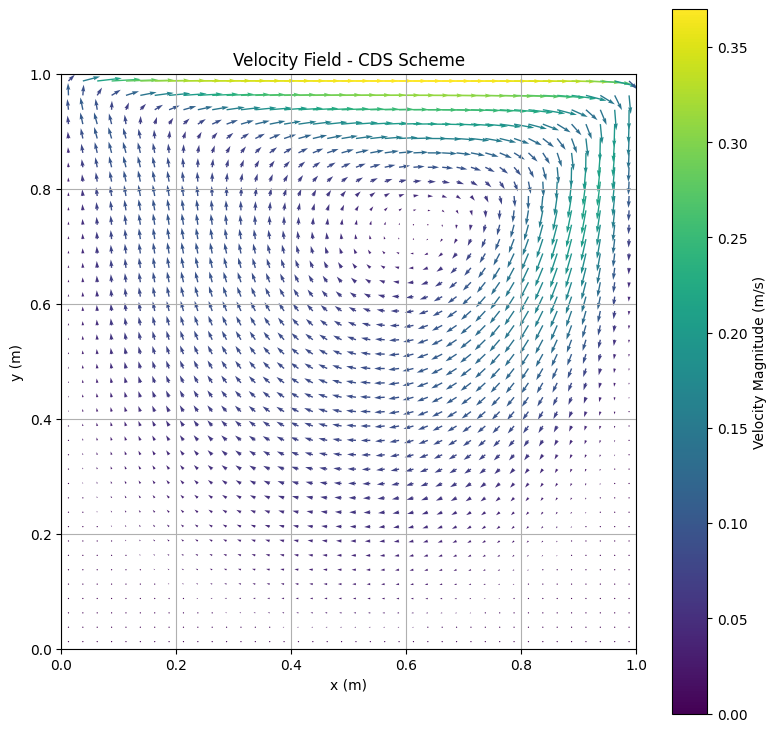

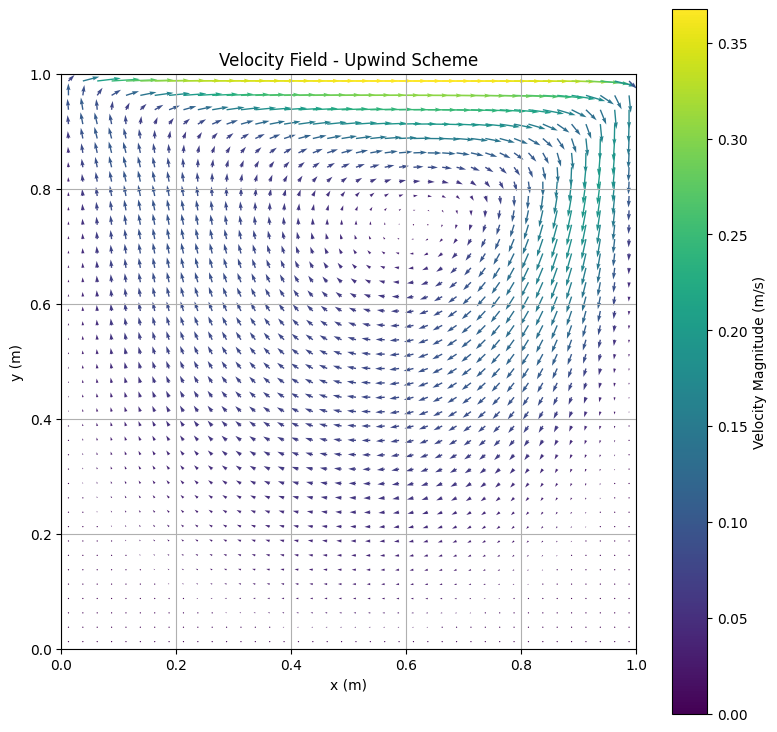

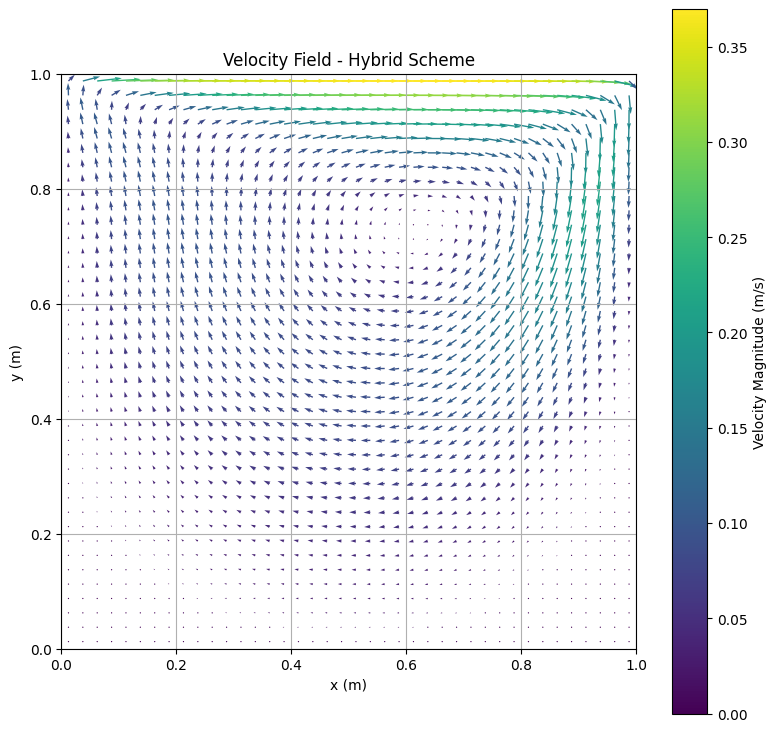

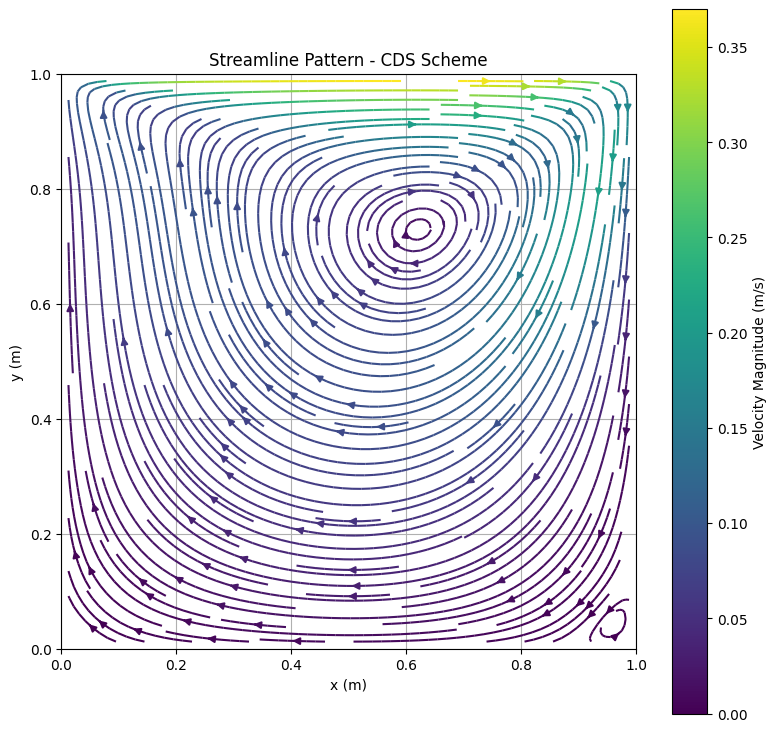

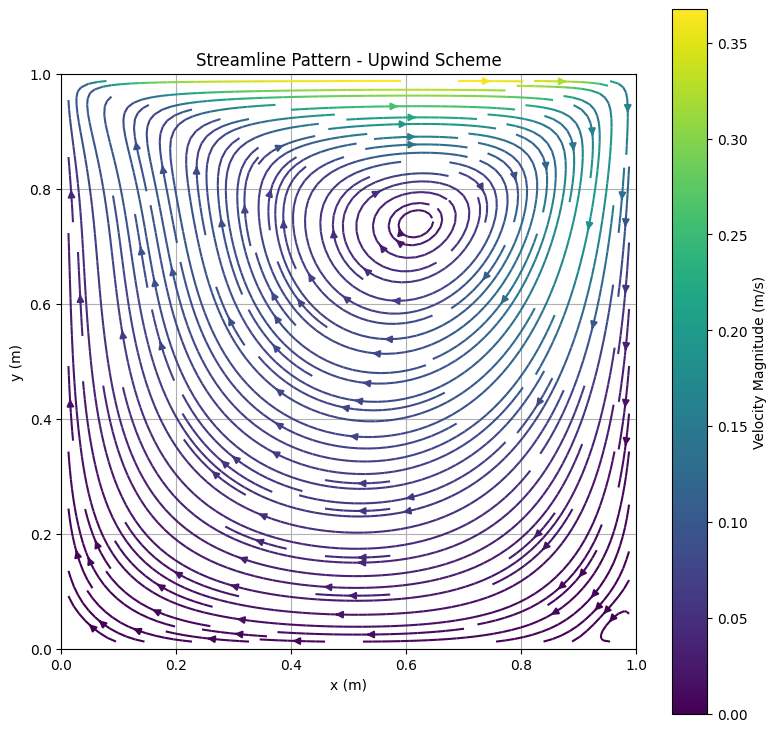

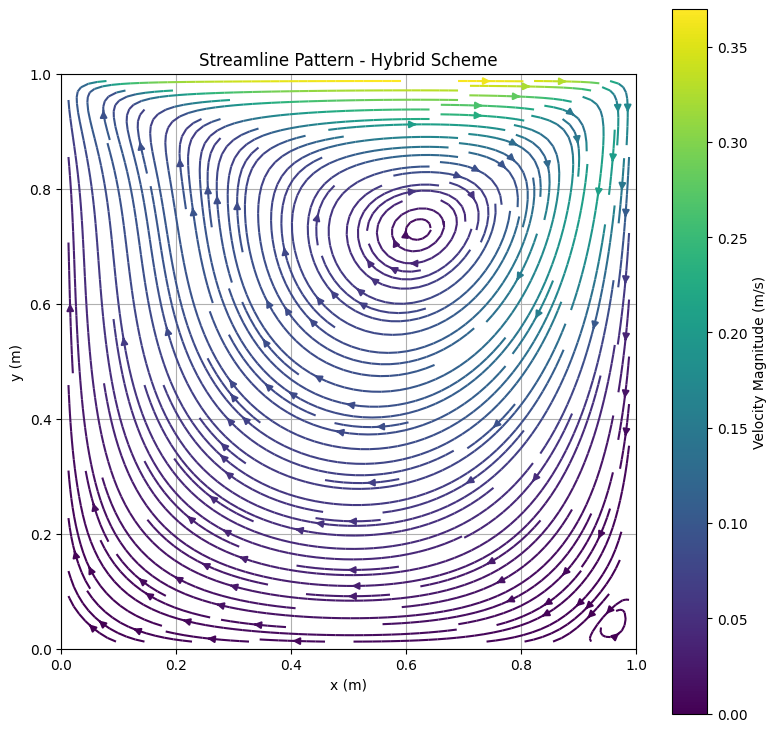

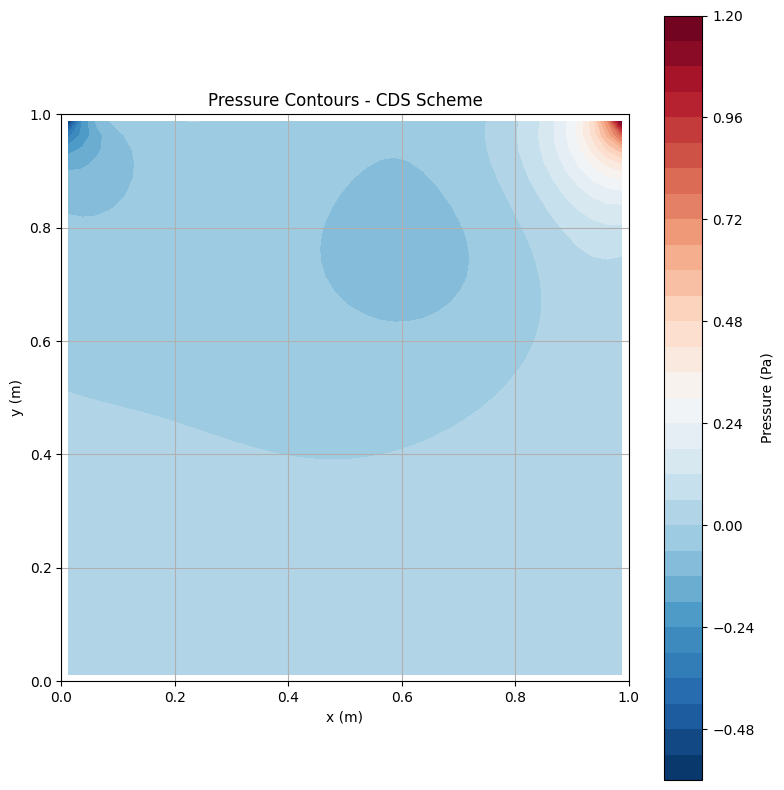

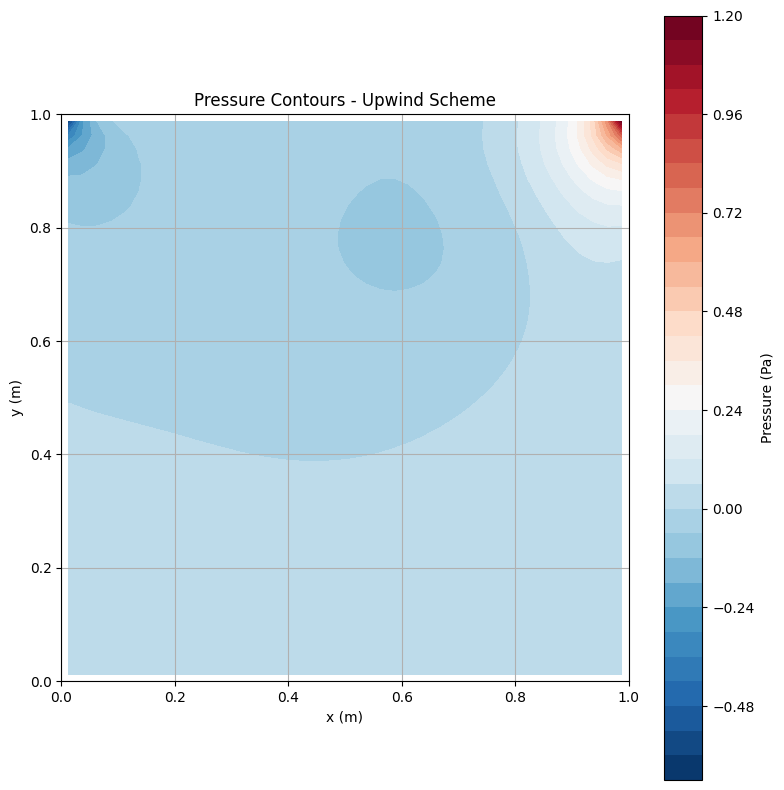

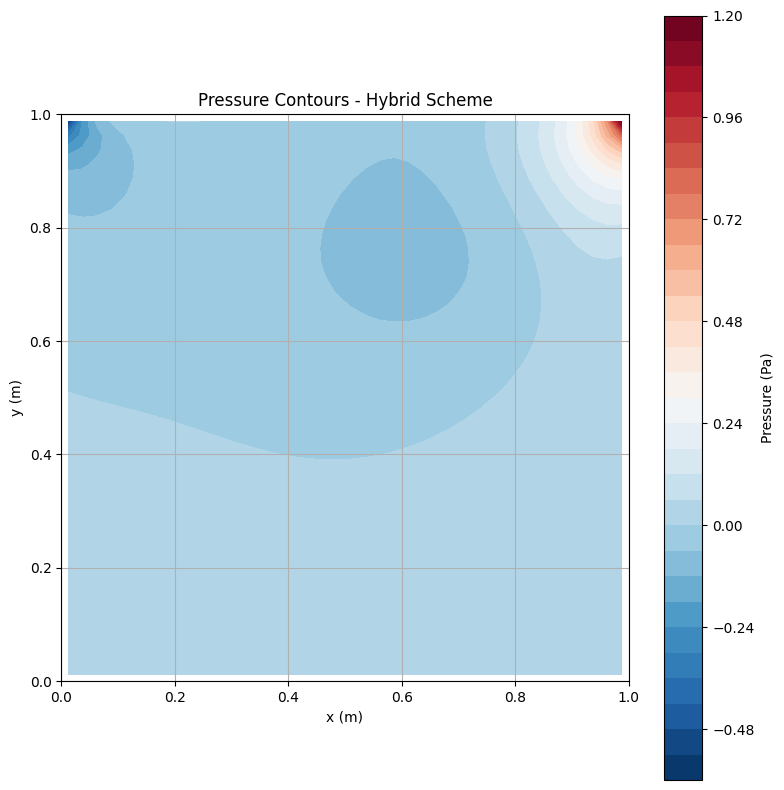

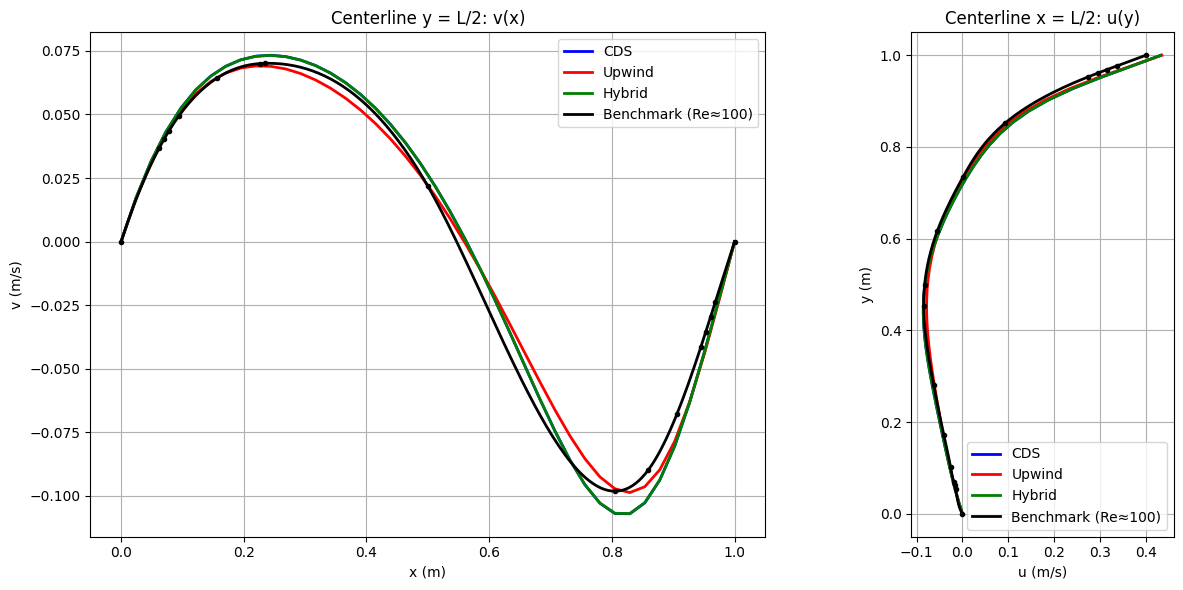

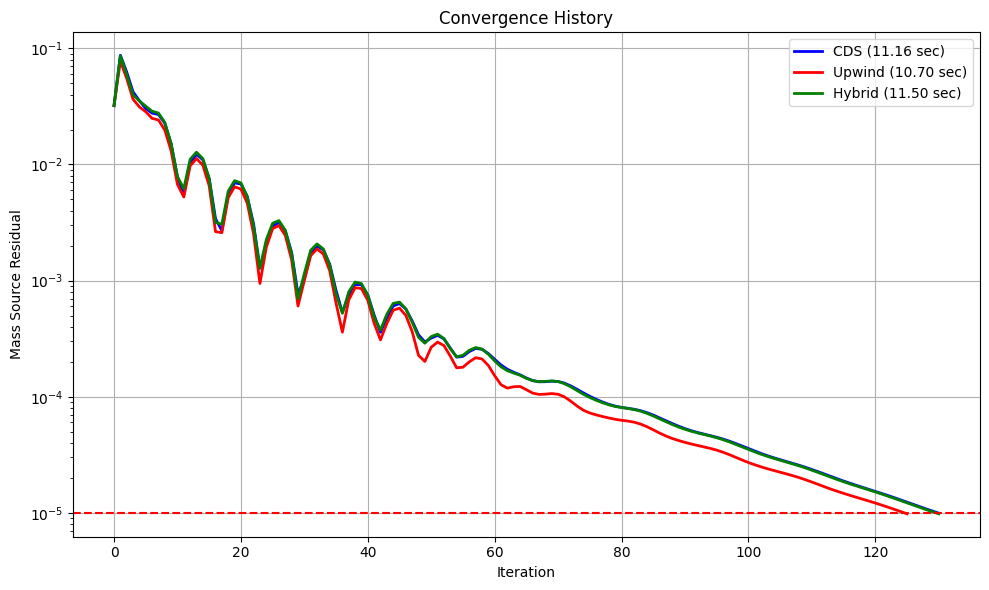

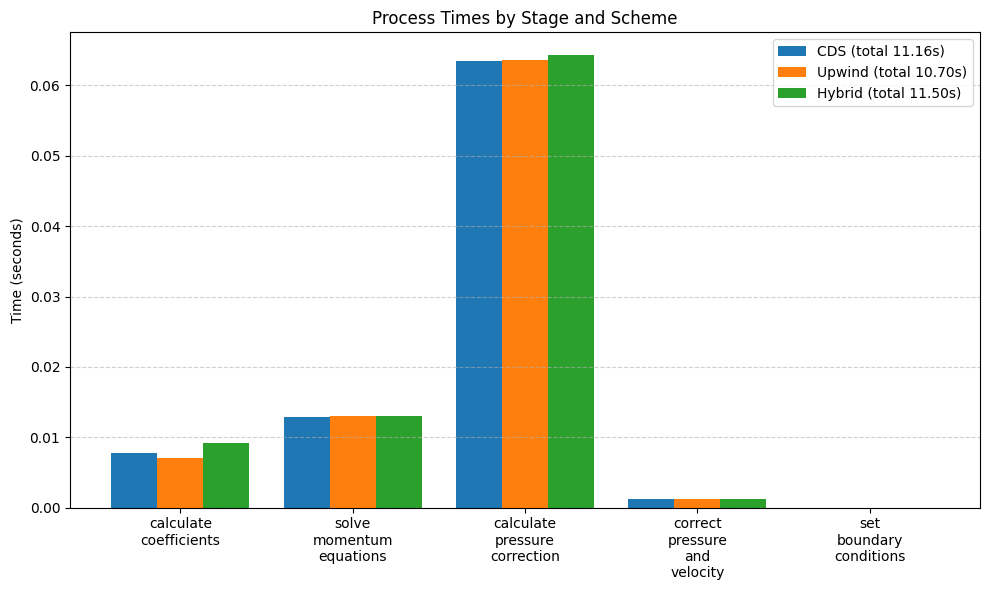


Comparison of schemes:
CDS: Final residual = 9.93277463e-06, Iterations = 131, Time = 11.16 sec
Upwind: Final residual = 9.81364620e-06, Iterations = 126, Time = 10.70 sec
Hybrid: Final residual = 9.81118809e-06, Iterations = 131, Time = 11.50 sec


In [119]:
# Main execution
if __name__ == "__main__":
    # Problem parameters
    # Defaults are overridden by CLI if provided
    logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
    length = 1  # 1m
    nx = ny = 40  # Number of grid cells
    rho = 1.0  # Density (kg/m^3)
    nu = 0.004  # Kinematic viscosity (m^2/s)
    u_lid = 0.4  # Lid velocity (m/s)

    # Run the simulation
    run_lid_driven_cavity(length, nx, ny, rho, nu, u_lid, max_iterations=2000)

In [ ]:
save = False
if save:
    import os, nbformat
    from nbconvert import PythonExporter

    output_path = os.path.splitext(os.path.basename('ldc_laminar.ipynb'))[0] + ".py"

    with open('ldc_laminar.ipynb', 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)

    source, _ = PythonExporter().from_notebook_node(nb)

    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(source)